# Graph ConvNet

Neural network based on the paper: `Joshi, Laurent, and Bresson, ‘An Efficient Graph Convolutional Network Technique for the Travelling Salesman Problem’.`

Open questions:
* Difference between Linear and Embedding layer.
* Does it make a difference that no two Linear layers were used for the edge layer?
* Why are the biases disabled for eq 2 and eq 3 - in the paper they are present?
* How does Batch Normalisation work?
* How are class weights calculated
* log_softmax and NLLLoss vs CrossEntropy (CrossEntropy calculation meaning)

In [1]:
LOAD_CHECKPOINT = True

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx

from model import GraphNet
from pathlib import Path
from torch.utils.data import DataLoader

from utils.data import Data, VRPDataset
from utils.loader import load_config
from utils.model import save_checkpoint, load_checkpoint

from sklearn.utils.class_weight import compute_class_weight
from torch.utils.tensorboard import SummaryWriter

## Model Inputs

| Variable | Meaning | Dimensions |
| -------- | ------- | ---------- |
| batch_edges | Adj matrix special connections* | B x num_nodes x num_nodes
| batch_edges_values | Distance Matrix | B x num_nodes x num_nodes
| batch_edges_target | Target adj matrix | B x num_nodes x num_nodes
| batch_nodes | Ones vector | B x num_nodes
| batch_nodes_coord | Coordinates | B x num_nodes x 2
| *batch_nodes_target* | Value represents ordering in tour | B x num_nodes


*special connections:
* 1 - k-nearest neighbour
* 2 - self connections
* 0 - otherwise

In [3]:
data_dir = Path('data')

train_dataset = torch.load(data_dir / 'vrp_20_train.pt')
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = torch.load(data_dir / 'vrp_20_test.pt')
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

len(train_dataloader), len(test_dataloader)

(313, 4)

In [4]:
def first(tensor): return tensor[0]
def get_batch(dl): return next(iter(dl))

## Visualise an instance

TODO: Shouldn't be required at this point

In [5]:
batch_features, batch_targets = get_batch(train_dataloader)
coords = first(batch_features[0]).cpu().numpy()
target = first(batch_targets).cpu().numpy()

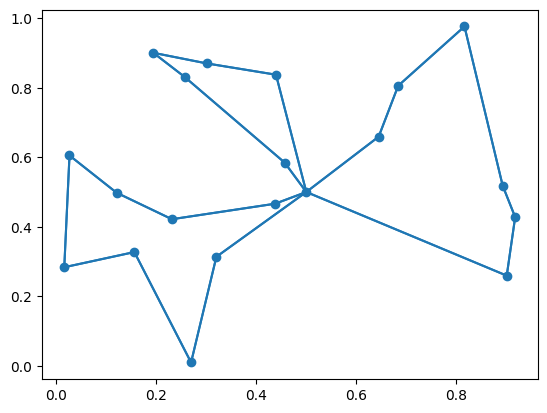

In [6]:
fig, ax = plt.subplots()

ax.scatter(coords[:, 0], coords[:, 1])

for i, row in enumerate(target):
    args = np.argwhere(row>0).flatten()
    x_i = coords[i]
    
    for x_j in coords[args]:
        ax.plot([x_i[0], x_j[0]], [x_i[1], x_j[1]], c='tab:blue')

plt.show()

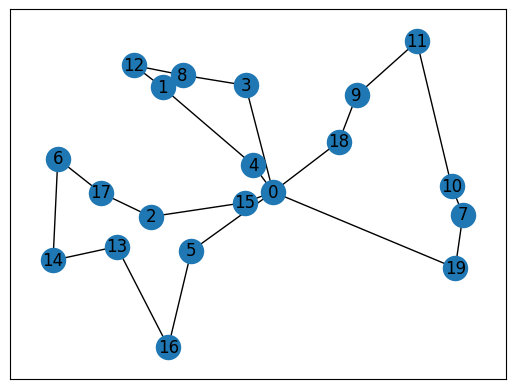

In [7]:
fig, ax = plt.subplots()

G = nx.from_numpy_array(target)
pos = dict(enumerate(coords))

nx.draw_networkx(G, pos, ax=ax)

plt.show()

## Compute class weights

Due to the class imbalance, we need to calculate the class weights.

In [8]:
targets = np.array([target_edges.cpu().numpy() for _, target_edges in train_dataset])

In [9]:
class_labels = targets.flatten()

edge_class_weights = compute_class_weight('balanced',
                                          classes=np.unique(class_labels),
                                          y=class_labels)
edge_class_weights = torch.tensor(edge_class_weights, dtype=torch.float)

In [10]:
edge_class_weights

tensor([0.5619, 4.5418])

## The Model

In [11]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Device", device)

Device cpu


In [12]:
config = load_config(num_gcn_layers=5, hidden_dim=16, node_features=3)
config.enable_dropout = True

In [13]:
LEARNING_RATE = 0.001

model = GraphNet(config).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss(edge_class_weights)

# tensorboard
# writer = SummaryWriter()

In [14]:
if LOAD_CHECKPOINT:
    print("Loading from checkpoint")
    checkpoint = load_checkpoint("model_20_dropout.pt")

    config = checkpoint['config']
    edge_class_weights = checkpoint['class_weights']
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

Loading from checkpoint


## Test Forward Pass

In [15]:
batch_coords, batch_demand, batch_edge_weights, batch_edge_values = batch_features

# ONLY A TEST
batch_node_features = torch.cat((batch_coords, batch_demand.unsqueeze(-1)), axis=-1)

y_pred = model.forward(batch_node_features, batch_edge_weights, batch_edge_values)

## Define metrics

In [16]:
from sklearn.metrics import accuracy_score, \
balanced_accuracy_score, precision_recall_fscore_support, precision_recall_curve

def get_metrics(targets, predictions):
    # Batch accuracy
    acc = accuracy_score(targets.flatten(), predictions.flatten())

    # Balanced accuracy
    bal_acc = balanced_accuracy_score(targets.flatten(), predictions.flatten(), adjusted=True)

    # Precision and Recall
    precision, recall, f1_score, _ = precision_recall_fscore_support(targets.flatten(),
                                                                     predictions.flatten(),
                                                                     average='binary')
    return acc, bal_acc, precision, recall, f1_score

## Validation loop

In [17]:
def validate(dl):
    targets = []
    predictions = []
    
    for batch_features, batch_targets in dl:
        batch_coords, batch_demand, batch_edge_weights, batch_edge_values = batch_features
        batch_coords = batch_coords.to(device)
        batch_demand = batch_demand.to(device)
        batch_edge_weights = batch_edge_weights.to(device)
        batch_edge_values = batch_edge_values.to(device)

        batch_targets = batch_targets.cpu().numpy()
    
        y_preds = eval_model(batch_coords, batch_demand, batch_edge_weights, batch_edge_values)
        y_preds = F.softmax(y_preds, dim=3)
        y_preds = y_preds.argmax(dim=3)
        y_preds = y_preds.cpu().numpy()
        
        targets.append(batch_targets)
        predictions.append(y_preds)
        
    targets = np.concatenate(targets)
    predictions = np.concatenate(predictions)
        
    return targets, predictions

## Training Loop

In [18]:
def get_loss(y_pred, y_target):
    y = y_pred.permute(0, 3, 1, 2)
    
    return criterion(y, y_target)

def train_one_epoch(batch_coords, batch_demand, batch_edge_weights, batch_edge_values, batch_targets):
    model.train()
    optimizer.zero_grad()
    
    # ONLY A TEST
    batch_node_features = torch.cat((batch_coords, batch_demand.unsqueeze(-1)), axis=-1)
    
    y_pred = model(batch_node_features, batch_edge_weights, batch_edge_values)
    y_pred = y_pred.permute(0, 3, 1, 2)
    
    loss = criterion(y_pred, batch_targets)
    loss.backward()
    
    optimizer.step()

    return loss

def train(num_epochs, dataloader):
    # TODO: Store all metrics over the epochs and return them
    epoch_losses = []
    
    for epoch in range(num_epochs):
        running_loss = 0
    
        for minibatch_idx, (batch_features, batch_targets) in enumerate(dataloader):
            batch_coords, batch_demand, batch_edge_weights, batch_edge_values = batch_features
            batch_coords = batch_coords.to(device)
            batch_demand = batch_demand.to(device)
            batch_edge_weights = batch_edge_weights.to(device)
            batch_edge_values = batch_edge_values.to(device)
            
            batch_targets = batch_targets.to(device)
            
            loss = train_one_epoch(batch_coords,
                                   batch_demand,
                                   batch_edge_weights,
                                   batch_edge_values,
                                   batch_targets)

            minibatch_loss = loss.item()
            running_loss += minibatch_loss
            
            writer.add_scalar("Loss/minibatch", minibatch_loss, minibatch_idx)

        # Losses
        epoch_loss = running_loss / len(dataloader)
        epoch_losses.append(epoch_loss)
        writer.add_scalar("Loss/train", epoch_loss, epoch)

        print(f'Epoch: {epoch:02d}, Loss: {epoch_loss:.4f}')
        
        # Evaluate metrics on test set
        targets, predictions = validate(test_dataloader)
        metrics = get_metrics(targets, predictions)
        acc, bal_acc, precision, recall, f1_score = metrics
        writer.add_scalar("Accuracy/test", acc, epoch)
        writer.add_scalar("Bal. Accuracy/test", bal_acc, epoch)
        writer.add_scalar("Precision/test", precision, epoch)
        writer.add_scalar("Recall/test", recall, epoch)
        writer.add_scalar("F1 Score/test", f1_score, epoch)

def eval_model(batch_coords, batch_demand, batch_edge_weights, batch_edge_values):
    model.eval()
    
    # ONLY A TEST
    batch_node_features = torch.cat((batch_coords, batch_demand.unsqueeze(-1)), axis=-1)

    with torch.no_grad():
        y_pred = model(batch_node_features, batch_edge_weights, batch_edge_values)

    return y_pred

In [19]:
print("Current config:", config, end='\n\n')

Current config: {'hidden_dim': 16, 'node_features': 3, 'edge_weight_features': 1, 'edge_values_features': 3, 'num_gcn_layers': 5, 'num_mlp_layers': 3}



In [ ]:
train(20, train_dataloader)

writer.flush()

Training with config: {'hidden_dim': 16, 'node_features': 3, 'edge_weight_features': 1, 'edge_values_features': 3, 'num_gcn_layers': 5, 'num_mlp_layers': 3, 'enable_dropout': True}

Epoch: 00, Loss: 0.3878
Epoch: 01, Loss: 0.3119
Epoch: 02, Loss: 0.2910
Epoch: 03, Loss: 0.2812
Epoch: 04, Loss: 0.2757
Epoch: 05, Loss: 0.2716
Epoch: 06, Loss: 0.2675
Epoch: 07, Loss: 0.2631
Epoch: 08, Loss: 0.2598
Epoch: 09, Loss: 0.2576


In [27]:
writer.close()

## Final metrics

In [20]:
targets, predictions = validate(test_dataloader)
acc, bal_acc, precision, recall, f1_score = get_metrics(targets, predictions)

print("Accuracy:", acc)
print("Balanced Accuracy:", bal_acc)
print("Precision:", precision)
print("Recall:", recall)
print("F1 score", f1_score)

Accuracy: 0.88805
Balanced Accuracy: 0.7989205109900475
Precision: 0.4955703211517165
Recall: 0.9140944167044939
F1 score 0.6427032633846645


## Plot the results

In [21]:
test_features, test_targets = get_batch(test_dataloader)
coords = test_features[0]

In [22]:
pred = eval_model(*test_features)
pred = F.softmax(pred, dim=3)
pred_prob = pred[..., 1].cpu().numpy()
pred_prob_argmax = pred.argmax(dim=3).cpu().numpy()

In [23]:
def adj_matrix_to_list(adj_matrix):
    adj_list = []
    
    for i, row in enumerate(adj_matrix):
        dest = np.argwhere(row>0).flatten()
        src = np.full(dest.size, i)
        
        adj_list.extend(zip(src, dest))
    
    return adj_list

def plot_edge_predictions(coords, pred, target, ax):
    G = nx.from_numpy_array(target)
    pos = dict(enumerate(coords))
    
    pred_edge_list = adj_matrix_to_list(pred)

    nx.draw_networkx(G, pos, ax=ax)
    nx.draw_networkx_edges(G, pos, edgelist=pred_edge_list, edge_color='red', alpha=0.1, width=3, ax=ax)

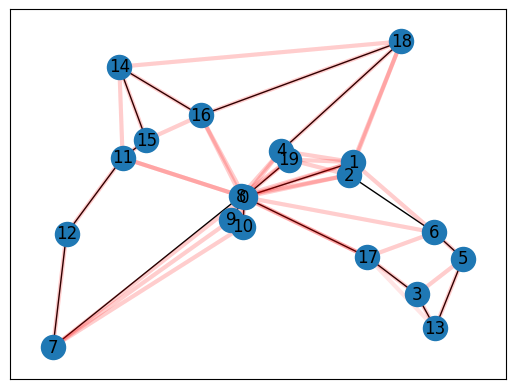

In [24]:
fig, ax = plt.subplots()
i = 0
plot_edge_predictions(coords[i].cpu().numpy(), pred_prob_argmax[i], test_targets[i].cpu().numpy(), ax=ax)

In [29]:
from utils.beam_search import Beamsearch

bs = Beamsearch(beam_width=100, trans_probs=torch.tensor(pred_prob), num_vehicles=2)
bs.search()

In [30]:
bs.sanity_check()

In [31]:
beams = bs.get_beam(0)

In [32]:
beams[0]

tensor([ 0,  8,  9, 10,  0, 17,  3, 13,  5,  6,  1,  2, 19,  4, 18, 14, 16, 15,
        11, 12,  7])

In [33]:
bs.get_beam(1)[0]

tensor([ 0, 10,  9,  8,  0, 17,  3, 13,  5,  6,  1,  2, 19,  4, 18, 14, 16, 15,
        11, 12,  7])

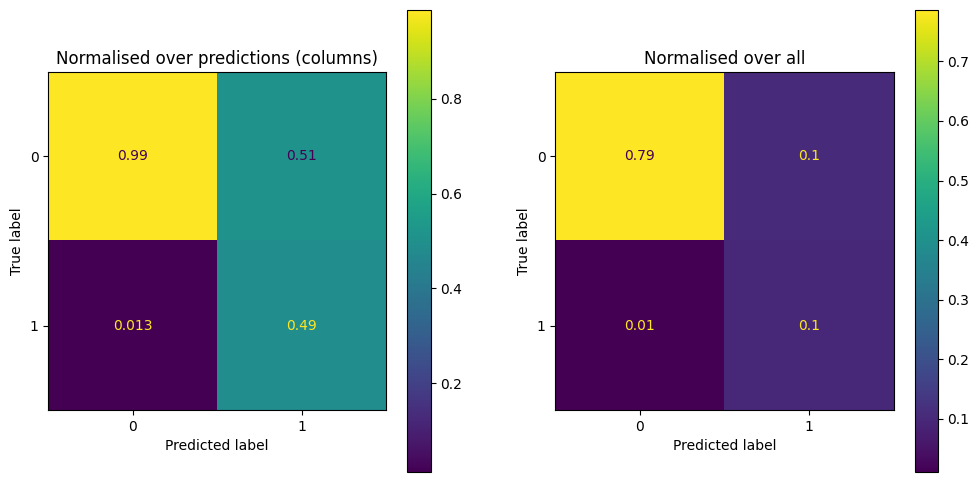

In [104]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

ConfusionMatrixDisplay.from_predictions(targets.flatten(), preds.flatten(), normalize='pred', ax=axes[0])
ConfusionMatrixDisplay.from_predictions(targets.flatten(), preds.flatten(), normalize='all', ax=axes[1])
axes[0].set_title("Normalised over predictions (columns)")
axes[1].set_title("Normalised over all")

plt.show()

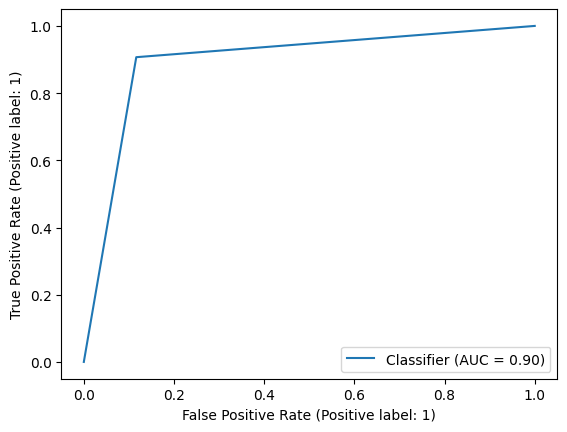

In [105]:
RocCurveDisplay.from_predictions(targets.flatten(), preds.flatten())

plt.show()

In [62]:
test_dataset[0]

((tensor([[0.5000, 0.5000],
          [0.0728, 0.3417],
          [0.1499, 0.1978],
          [0.5410, 0.9485],
          [0.2201, 0.7604],
          [0.9163, 0.8817],
          [0.6853, 0.2891],
          [0.5735, 0.8954],
          [0.9772, 0.8555],
          [0.1192, 0.3076],
          [0.3896, 0.2627],
          [0.7536, 0.6476],
          [0.0743, 0.1794],
          [0.2093, 0.9920],
          [0.8517, 0.3653],
          [0.4880, 0.0255],
          [0.3550, 0.7131],
          [0.0496, 0.9530],
          [0.4468, 0.2888],
          [0.6735, 0.1945]]),
  tensor([ 0., 10., 10.,  9.,  5.,  7.,  6., 10.,  3.,  1.,  9.,  5.,  5.,  6.,
           2., 10.,  5.,  6.,  7., 10.]),
  tensor([[0.0000, 0.4556, 0.4625, 0.4503, 0.3823, 0.5648, 0.2807, 0.4021, 0.5950,
           0.4267, 0.2617, 0.2934, 0.5329, 0.5715, 0.3767, 0.4746, 0.2578, 0.6388,
           0.2178, 0.3513],
          [0.4556, 0.0000, 0.1632, 0.7664, 0.4438, 1.0015, 0.6148, 0.7465, 1.0401,
           0.0575, 0.3265, 0.7464, 0.16